# 뉴스 카테고리 다중분류 프로젝트

본인:  
- Multinominal Naive Bayes
- Support Vector Machine
- Gradient Boosting Classifier

나머지 팀원:  
- Logistic Regression
- Complement Naive Bayes Classifier(CNB)
- Decision Tree
- Random Forest
- Voting
- 1-D CNN  

위의 모델들로 vocab size에 따른 분류 성능을 비교한다.  

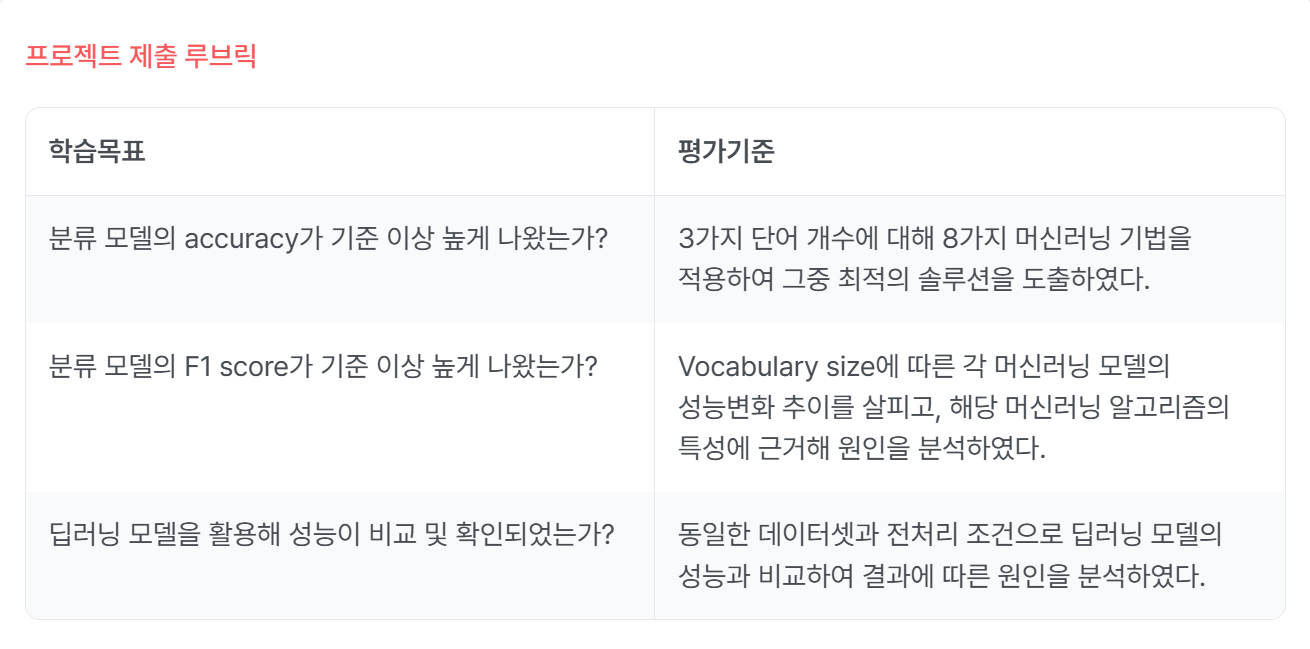

# 라이브러리 및 데이터 로드

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import reuters
import time
from tqdm import tqdm

# Sklearn(ML) 관련 라이브러리
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# TensorFlow/Keras(DL) 관련 라이브러리
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [2]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2) # num_words 일단 미지정

# word index 사전
word_index = reuters.get_word_index()

# 0, 1, 2는 pad, sos, unk 토큰이므로 이후의 토큰들에 대해 3을 더해줘야 한다.
index_to_word = {index + 3 : word for word, index in word_index.items()}
index_to_word[0] = "<pad>"
index_to_word[1] = "<sos>"
index_to_word[2] = "<unk>"

# 디코딩
def decode_review(encoded):
    return " ".join(index_to_word.get(i, "<unk>") for i in encoded)

train_texts_all = [decode_review(seq) for seq in x_train]
test_texts_all = [decode_review(seq) for seq in x_test]

# sample 확인
print(train_texts_all[:3])
print(test_texts_all[:3])

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
550378/550378 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step
['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3", '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 

# 벡터화 & 모델 학습 및 평가

In [ ]:
# num_words 리스트
num_words_list = [3000, 5000, 10000, 20000]

# num_words별 학습 루프
results = []

for num_words in num_words_list:
    print(f"\n=== num_words = {num_words} ===")
    start_time = time.time()

    # num_words가 바뀔 때마다 정의해줘야 한다.
    vectorizer = TfidfVectorizer(max_features=num_words) # TF-IDF
    X_train = vectorizer.fit_transform(train_texts_all)
    X_test = vectorizer.transform(test_texts_all)

    # 모델 정의
    models = {
        "MultinomialNB": MultinomialNB(),
        "LinearSVM": LinearSVC(C=1, penalty='l2', max_iter=1000, dual=False, random_state=42, verbose=3),
        "GradientBoosting": GradientBoostingClassifier(random_state=42, verbose=3)
    }

    # tqdm으로 모델 진행률 표시
    for model_name, model in tqdm(models.items(), desc="Training models"):
        model_start = time.time()  # 모델별 시작 시간
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro") # 다중분류 문제이므로 디폴트 binary에서 수정했다.

        results.append([num_words, model_name, acc, f1])

        model_time = time.time() - model_start
        print(f"{model_name:18s}  Acc = {acc:.4f},  F1 = {f1:.4f}  (Elapsed: {model_time:.1f}s)")

    loop_time = time.time() - start_time
    print(f"num_words = {num_words} loop finished in {loop_time:.1f}s")


=== num_words = 3000 ===


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6915,  F1 = 0.1511  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LinearSVM           Acc = 0.8290,  F1 = 0.6818  (Elapsed: 3.1s)
      Iter       Train Loss   Remaining Time 
         1           1.4754           26.03m
         2     2170902.5562           25.77m
         3     2178222.9292           25.46m
         4 21474141373481801880539660292837384513152868921502682100460605685849575561088186503676484803401944091590656.0000           25.38m
         5 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           25.04m
         6 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           24.73m
         7 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           24.52m
         8 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           24.26m
         9 214741413846332049627948748405071522616

Training models: 100%|██████████| 3/3 [26:26<00:00, 528.70s/it]

GradientBoosting    Acc = 0.7671,  F1 = 0.5678  (Elapsed: 1583.0s)
num_words = 3000 loop finished in 1587.3s

=== num_words = 5000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6785,  F1 = 0.1156  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:03<00:01,  1.74s/it]

LinearSVM           Acc = 0.8264,  F1 = 0.6773  (Elapsed: 3.4s)
      Iter       Train Loss   Remaining Time 
         1           1.4490           28.00m
         2       40908.7538           27.42m
         3 507386373254545301171270622300401900664239098999186510753534157627850752.0000           27.28m
         4 507386373254545301171270622300401900664239098999186510753534157627850752.0000           26.95m
         5 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800775576570599327399271457967981198058490691584.0000           26.63m
         6 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800775576570599327399271457967981198058490691584.0000           26.45m
         7 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800775576570599327399271457967981198058490691584.0000           26.14m
         8 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800

Training models: 100%|██████████| 3/3 [28:04<00:00, 561.36s/it]

GradientBoosting    Acc = 0.7707,  F1 = 0.5429  (Elapsed: 1680.6s)
num_words = 5000 loop finished in 1685.3s

=== num_words = 10000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6576,  F1 = 0.0957  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:06<00:03,  3.10s/it]

LinearSVM           Acc = 0.8299,  F1 = 0.6868  (Elapsed: 6.1s)
      Iter       Train Loss   Remaining Time 
         1           1.4376           29.20m
         2     1451223.6053           29.06m
         3   512394330.6927           28.97m
         4 537662674510088896.0000           28.62m
         5 537662676003913472.0000           28.48m
         6 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           28.14m
         7 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           27.93m
         8 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           27.59m
         9 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           27.36m
        10 656173127080591140189446

Training models: 100%|██████████| 3/3 [30:12<00:00, 604.29s/it]

GradientBoosting    Acc = 0.7738,  F1 = 0.5818  (Elapsed: 1806.7s)
num_words = 10000 loop finished in 1814.1s

=== num_words = 20000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6149,  F1 = 0.0752  (Elapsed: 0.1s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:05<00:02,  2.61s/it]

LinearSVM           Acc = 0.8295,  F1 = 0.6888  (Elapsed: 5.2s)
      Iter       Train Loss   Remaining Time 
         1           1.4499           31.80m
         2       95438.0645           31.40m
         3      105523.0476           31.24m
         4 51177387637840133525066847369163319035272223522816.0000           30.82m
         5 95885311931365363565841483911792018150859004841650407902802809941131264.0000           30.64m
         6 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271342325626830814869696020480.0000           30.39m
         7 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271342325626830814869696020480.0000           30.05m
         8 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271342325626830814869696020480.0000           29.79m
         9 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271

Training models: 100%|██████████| 3/3 [32:24<00:00, 648.30s/it]

GradientBoosting    Acc = 0.7720,  F1 = 0.5912  (Elapsed: 1939.7s)
num_words = 20000 loop finished in 1946.5s



===== 결과표 =====
    num_words             model  accuracy  f1_macro
0        3000     MultinomialNB  0.691451  0.151085
1        3000         LinearSVM  0.829029  0.681764
2        3000  GradientBoosting  0.767142  0.567806
3        5000     MultinomialNB  0.678540  0.115606
4        5000         LinearSVM  0.826358  0.677293
5        5000  GradientBoosting  0.770703  0.542851
6       10000     MultinomialNB  0.657614  0.095660
7       10000         LinearSVM  0.829920  0.686804
8       10000  GradientBoosting  0.773820  0.581831
9       20000     MultinomialNB  0.614871  0.075212
10      20000         LinearSVM  0.829475  0.688760
11      20000  GradientBoosting  0.772039  0.591218


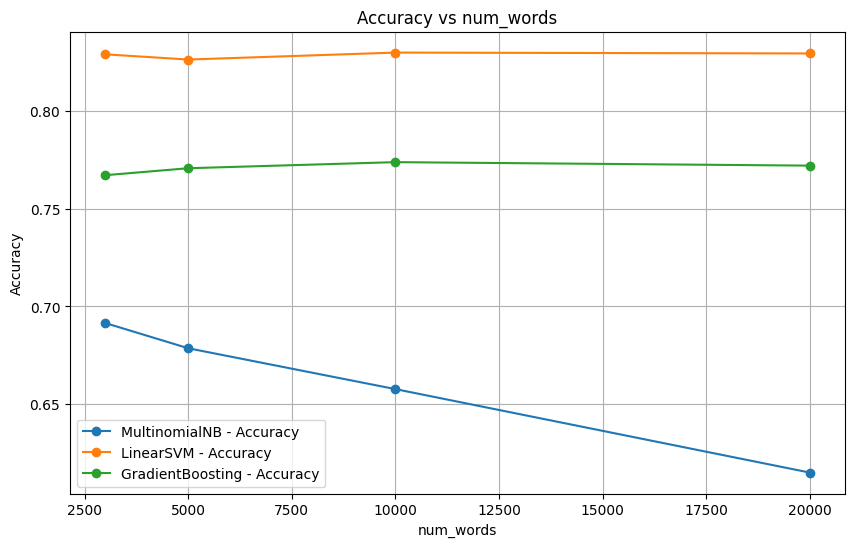

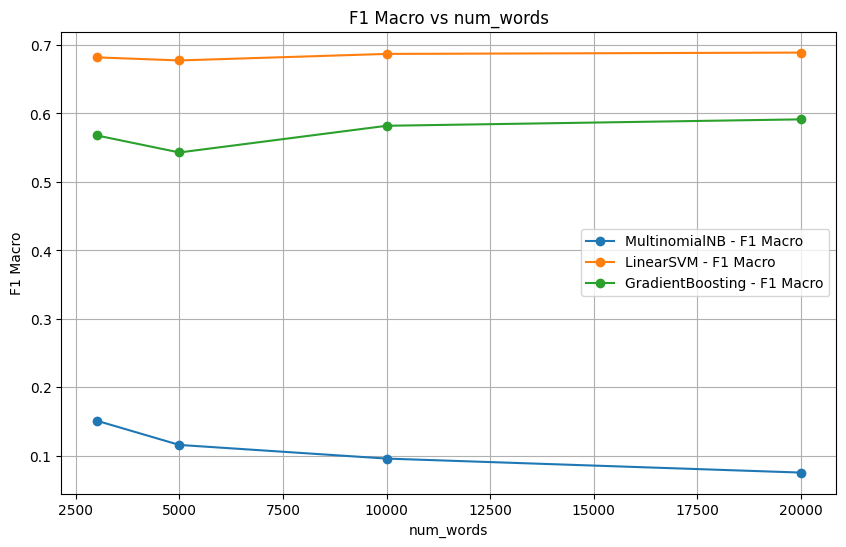

In [ ]:
# 결과 DataFrame 생성 + 시각화
df_results = pd.DataFrame(results, columns=["num_words", "model", "accuracy", "f1_macro"])
print("\n===== 결과표 =====")
print(df_results)

# 시각화
plt.figure(figsize=(10,6))
for model_name in df_results["model"].unique():
    subset = df_results[df_results["model"] == model_name]
    plt.plot(subset["num_words"], subset["accuracy"], marker='o', label=f"{model_name} - Accuracy")

plt.title("Accuracy vs num_words")
plt.xlabel("num_words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for model_name in df_results["model"].unique():
    subset = df_results[df_results["model"] == model_name]
    plt.plot(subset["num_words"], subset["f1_macro"], marker='o', label=f"{model_name} - F1 Macro")

plt.title("F1 Macro vs num_words")
plt.xlabel("num_words")
plt.ylabel("F1 Macro")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#df_results.to_csv("MNB_SVM_GBC.csv", index=False)

# 나머지 모델들 추가 분석

In [4]:
# GPU 설정 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 증가를 허용하도록 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# y_train 레이블에서 고유한 클래스 개수를 계산
num_classes = len(np.unique(y_train))
print(f"데이터 확인 완료. 총 클래스 개수: {num_classes}")


# 실험 설정
num_words_list = [3000, 5000, 10000, 20000]
results = []

# 1D-CNN 하이퍼파라미터
EMBEDDING_DIM = 128
MAXLEN = 150
CNN_EPOCHS = 5
CNN_BATCH_SIZE = 64


# num_words 별 학습 루프 시작
for num_words in num_words_list:
    print(f"\n{'='*25} num_words = {num_words} {'='*25}")
    loop_start_time = time.time()

    # A. Sklearn 모델 (TF-IDF 기반)
    print(f"\n[INFO] (A) Sklearn 모델 (TF-IDF, max_features={num_words}) 학습 시작...")

    # A-1. TF-IDF 벡터화
    vectorizer = TfidfVectorizer(max_features=num_words)
    X_train_tfidf = vectorizer.fit_transform(train_texts_all)
    X_test_tfidf = vectorizer.transform(test_texts_all)

    # A-2. Sklearn 모델 정의
    # Voting을 위한 기본 모델 정의
    clf_lr = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
    clf_cnb = ComplementNB()

    models = {
        # 신규 모델
        "LogisticRegression": clf_lr,
        "ComplementNB": clf_cnb,
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1, verbose=0),
        "Voting (LR+CNB)": VotingClassifier(
            estimators=[('lr', clf_lr), ('cnb', clf_cnb)],
            voting='hard',
            n_jobs=-1
        )
    }

    # A-3. Sklearn 모델 학습 및 평가
    for model_name, model in tqdm(models.items(), desc="Training Sklearn models"):
        model_start = time.time()

        if model_name == "GradientBoosting" or model_name == "RandomForest" or model_name == "DecisionTree":
            model.fit(X_train_tfidf.toarray(), y_train)
        else:
            model.fit(X_train_tfidf, y_train)

        preds = model.predict(X_test_tfidf.toarray() if model_name in ["GradientBoosting", "RandomForest", "DecisionTree"] else X_test_tfidf)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")

        results.append([num_words, model_name, acc, f1])
        model_time = time.time() - model_start
        print(f"{model_name:20s} Acc = {acc:.4f}, F1 = {f1:.4f} (Elapsed: {model_time:.1f}s)")

    # B. 1-D CNN
    print(f"\n[INFO] (B) 1-D CNN 모델 (Tokenizer, num_words={num_words}) 학습 시작...")
    model_start = time.time()

    # B-1. Keras 토큰화 및 시퀀스 패딩
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts_all)

    X_train_seq = tokenizer.texts_to_sequences(train_texts_all)
    X_test_seq = tokenizer.texts_to_sequences(test_texts_all)

    X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=MAXLEN)
    X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=MAXLEN)

    # B-2. 레이블 원-핫 인코딩
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # B-3. 1-D CNN 모델 정의
    def create_cnn_model(vocab_size, embedding_dim, maxlen, num_classes):
        model = Sequential([
            # 1. Embedding Layer: (num_words) 크기의 사전을 (EMBEDDING_DIM) 차원으로 압축
            Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=maxlen),
            Dropout(0.3),

            # 2. 1D Convolution Layer: 128개의 5-gram 필터 적용
            Conv1D(128, 5, activation='relu'),

            # 3. Pooling Layer: 가장 중요한 특징(max)만 추출
            GlobalMaxPooling1D(),

            # 4. Fully Connected Layers
            Dense(64, activation='relu'),
            Dropout(0.4),

            # 5. Output Layer: num_classes 개수만큼의 노드로 분류 (다중분류)
            Dense(num_classes, activation='softmax')
        ])

        model.compile(loss='categorical_crossentropy', # 다중 분류 손실 함수
                      optimizer='adam',
                      metrics=['accuracy'])
        return model

    # B-4. CNN 모델 생성 및 학습
    model_cnn = create_cnn_model(num_words, EMBEDDING_DIM, MAXLEN, num_classes)

    model_cnn.fit(X_train_pad, y_train_cat,
                  epochs=CNN_EPOCHS,
                  batch_size=CNN_BATCH_SIZE,
                  validation_split=0.1,
                  verbose=0)

    # B-5. CNN 모델 평가
    preds_proba_cnn = model_cnn.predict(X_test_pad)
    preds_cnn = np.argmax(preds_proba_cnn, axis=1)

    acc_cnn = accuracy_score(y_test, preds_cnn)
    f1_cnn = f1_score(y_test, preds_cnn, average="macro")

    results.append([num_words, "1-D CNN", acc_cnn, f1_cnn])
    model_time = time.time() - model_start
    print(f"{'1-D CNN':20s} Acc = {acc_cnn:.4f}, F1 = {f1_cnn:.4f} (Elapsed: {model_time:.1f}s)")

    # 루프 종료
    loop_time = time.time() - loop_start_time
    print(f"\n--- num_words = {num_words} loop finished in {loop_time:.1f}s ---")


# 최종 결과 출력
print("\n\n" + "="*40)
print("      Total Experiment Results")
print("="*40)

df_results = pd.DataFrame(results, columns=["Num Words", "Model", "Accuracy", "F1 Score"])

# 보기 좋게 정렬
df_results = df_results.sort_values(by=["Num Words", "F1 Score"], ascending=[True, False])
print(df_results.to_string(index=False, float_format="%.4f"))

데이터 확인 완료. 총 클래스 개수: 46

========================= num_words = 3000 =========================

[INFO] (A) Sklearn 모델 (TF-IDF, max_features=3000) 학습 시작...


Training Sklearn models:  20%|██        | 1/5 [00:05<00:22,  5.62s/it]

LogisticRegression   Acc = 0.8019, F1 = 0.4785 (Elapsed: 5.6s)
ComplementNB         Acc = 0.7631, F1 = 0.4188 (Elapsed: 0.0s)


Training Sklearn models:  60%|██████    | 3/5 [00:15<00:10,  5.25s/it]

DecisionTree         Acc = 0.6999, F1 = 0.4604 (Elapsed: 10.2s)


Training Sklearn models:  80%|████████  | 4/5 [00:27<00:07,  7.58s/it]

RandomForest         Acc = 0.7711, F1 = 0.4635 (Elapsed: 12.0s)


Training Sklearn models: 100%|██████████| 5/5 [00:33<00:00,  6.64s/it]

Voting (LR+CNB)      Acc = 0.7743, F1 = 0.3865 (Elapsed: 5.4s)

[INFO] (B) 1-D CNN 모델 (Tokenizer, num_words=3000) 학습 시작...



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1-D CNN              Acc = 0.7262, F1 = 0.1993 (Elapsed: 20.5s)

--- num_words = 3000 loop finished in 54.7s ---

========================= num_words = 5000 =========================

[INFO] (A) Sklearn 모델 (TF-IDF, max_features=5000) 학습 시작...


Training Sklearn models:  20%|██        | 1/5 [00:06<00:24,  6.16s/it]

LogisticRegression   Acc = 0.7988, F1 = 0.4749 (Elapsed: 6.2s)
ComplementNB         Acc = 0.7694, F1 = 0.4687 (Elapsed: 0.0s)


Training Sklearn models:  60%|██████    | 3/5 [00:20<00:13,  6.89s/it]

DecisionTree         Acc = 0.7030, F1 = 0.4443 (Elapsed: 14.2s)


Training Sklearn models:  80%|████████  | 4/5 [00:36<00:10, 10.00s/it]

RandomForest         Acc = 0.7618, F1 = 0.4461 (Elapsed: 15.9s)


Training Sklearn models: 100%|██████████| 5/5 [00:42<00:00,  8.54s/it]

Voting (LR+CNB)      Acc = 0.7778, F1 = 0.4166 (Elapsed: 6.4s)

[INFO] (B) 1-D CNN 모델 (Tokenizer, num_words=5000) 학습 시작...



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1-D CNN              Acc = 0.7382, F1 = 0.2122 (Elapsed: 11.8s)

--- num_words = 5000 loop finished in 55.5s ---

========================= num_words = 10000 =========================

[INFO] (A) Sklearn 모델 (TF-IDF, max_features=10000) 학습 시작...


Training Sklearn models:  20%|██        | 1/5 [00:07<00:30,  7.54s/it]

LogisticRegression   Acc = 0.7965, F1 = 0.4624 (Elapsed: 7.5s)
ComplementNB         Acc = 0.7734, F1 = 0.4876 (Elapsed: 0.1s)


Training Sklearn models:  60%|██████    | 3/5 [00:29<00:20, 10.10s/it]

DecisionTree         Acc = 0.6955, F1 = 0.4317 (Elapsed: 21.9s)


Training Sklearn models:  80%|████████  | 4/5 [00:54<00:15, 15.30s/it]

RandomForest         Acc = 0.7493, F1 = 0.4312 (Elapsed: 25.1s)


Training Sklearn models: 100%|██████████| 5/5 [01:02<00:00, 12.59s/it]

Voting (LR+CNB)      Acc = 0.7716, F1 = 0.3834 (Elapsed: 8.3s)

[INFO] (B) 1-D CNN 모델 (Tokenizer, num_words=10000) 학습 시작...



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1-D CNN              Acc = 0.7275, F1 = 0.1930 (Elapsed: 12.2s)

--- num_words = 10000 loop finished in 76.1s ---

========================= num_words = 20000 =========================

[INFO] (A) Sklearn 모델 (TF-IDF, max_features=20000) 학습 시작...


Training Sklearn models:  20%|██        | 1/5 [00:13<00:53, 13.28s/it]

LogisticRegression   Acc = 0.7934, F1 = 0.4583 (Elapsed: 13.3s)
ComplementNB         Acc = 0.7685, F1 = 0.4608 (Elapsed: 0.0s)


Training Sklearn models:  60%|██████    | 3/5 [00:47<00:32, 16.03s/it]

DecisionTree         Acc = 0.6972, F1 = 0.4407 (Elapsed: 33.9s)


Training Sklearn models:  80%|████████  | 4/5 [01:28<00:24, 24.86s/it]

RandomForest         Acc = 0.7462, F1 = 0.3837 (Elapsed: 41.6s)


Training Sklearn models: 100%|██████████| 5/5 [01:42<00:00, 20.44s/it]

Voting (LR+CNB)      Acc = 0.7676, F1 = 0.3786 (Elapsed: 13.4s)

[INFO] (B) 1-D CNN 모델 (Tokenizer, num_words=20000) 학습 시작...



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1-D CNN              Acc = 0.7142, F1 = 0.1629 (Elapsed: 12.7s)

--- num_words = 20000 loop finished in 115.9s ---


      Total Experiment Results
 Num Words              Model  Accuracy  F1 Score
      3000 LogisticRegression    0.8019    0.4785
      3000       RandomForest    0.7711    0.4635
      3000       DecisionTree    0.6999    0.4604
      3000       ComplementNB    0.7631    0.4188
      3000    Voting (LR+CNB)    0.7743    0.3865
      3000            1-D CNN    0.7262    0.1993
      5000 LogisticRegression    0.7988    0.4749
      5000       ComplementNB    0.7694    0.4687
      5000       RandomForest    0.7618    0.4461
      5000       DecisionTree    0.7030    0.4443
      5000    Voting (LR+CNB)    0.7778    0.4166
      5000            1-D CNN    0.7382    0.2122
     10000       ComplementNB    0.7734    0.4876
     10000 LogisticRegression    0.7965    0.4624
     10000       DecisionTree    0.6955    0.4317
     10000   

In [6]:
df_results

,Num Words,Model,Accuracy,F1 Score
0,3000,LogisticRegression,0.801870,0.478454
3,3000,RandomForest,0.771149,0.463534
2,3000,DecisionTree,0.699911,0.460421
1,3000,ComplementNB,0.763134,0.418765
4,3000,Voting (LR+CNB),0.774265,0.386548
5,3000,1-D CNN,0.726180,0.199322
6,5000,LogisticRegression,0.798753,0.474870
7,5000,ComplementNB,0.769368,0.468682
9,5000,RandomForest,0.761799,0.446060
8,5000,DecisionTree,0.703028,0.444325


## 최종 결과 결합 및 시각화

In [12]:
old = pd.read_csv("/content/MNB_SVM_GBC.csv")
old.columns = ["Num Words", "Model", "Accuracy", "F1 Score"]

final_df = pd.concat([old, df_results], axis=0, ignore_index=True)
final_df

,Num Words,Model,Accuracy,F1 Score
0,3000,MultinomialNB,0.691451,0.151085
1,3000,LinearSVM,0.829029,0.681764
2,3000,GradientBoosting,0.767142,0.567806
3,5000,MultinomialNB,0.678540,0.115606
4,5000,LinearSVM,0.826358,0.677293
5,5000,GradientBoosting,0.770703,0.542851
6,10000,MultinomialNB,0.657614,0.095660
7,10000,LinearSVM,0.829920,0.686804
8,10000,GradientBoosting,0.773820,0.581831
9,20000,MultinomialNB,0.614871,0.075212


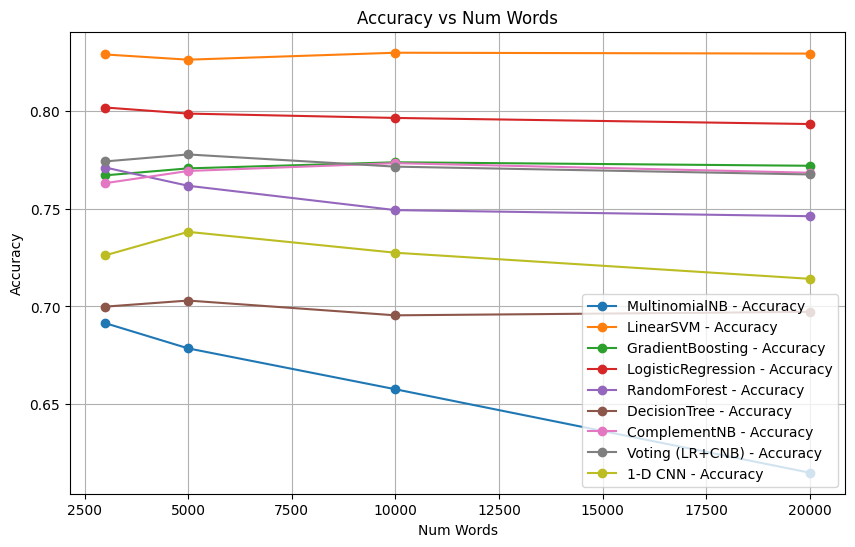

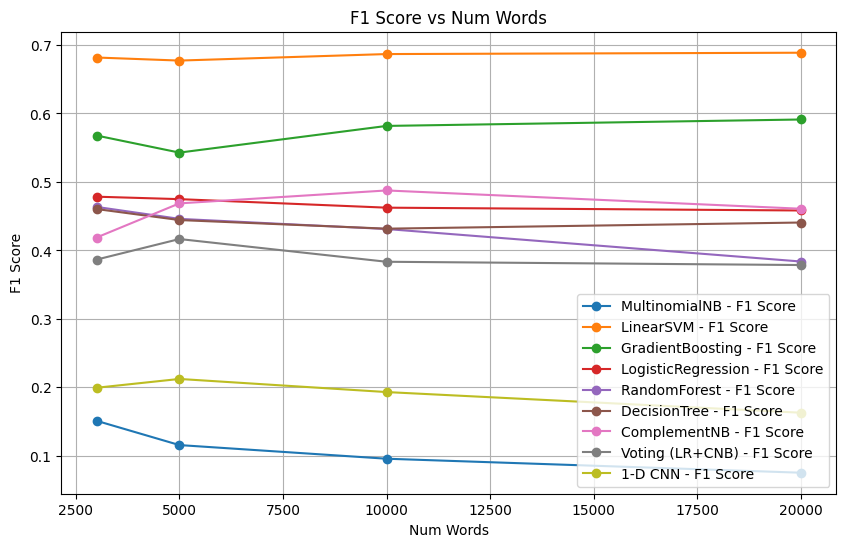

In [13]:
# 시각화
plt.figure(figsize=(10,6))
for model_name in final_df["Model"].unique():
    subset = final_df[final_df["Model"] == model_name]
    plt.plot(subset["Num Words"], subset["Accuracy"], marker='o', label=f"{model_name} - Accuracy")

plt.title("Accuracy vs Num Words")
plt.xlabel("Num Words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for model_name in final_df["Model"].unique():
    subset = final_df[final_df["Model"] == model_name]
    plt.plot(subset["Num Words"], subset["F1 Score"], marker='o', label=f"{model_name} - F1 Score")

plt.title("F1 Score vs Num Words")
plt.xlabel("Num Words")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#final_df.to_csv("ML_models.csv", index=False)

- 두 지표 모두에서 가장 좋은 결과를 보이는 모델은 LinearSVM이다.  
- 두 지표 모두에서 가장 안 좋은 결과를 보이는 모델은 MultinomialNB이며, num_words가 커질수록 Acc는 하락하는 경향이 있다.  
- 1D CNN은 epoch가 적어서 그런지 기대만큼 좋은 성능을 보이지는 못 한다.
- num_words가 커질수록 모든 모델들의 성능이 대체로 낮아지는 경향이 있지만, 유의하게 큰 차이인지는 모르겠다.
    - num_words가 커질수록 TF-IDF 차원이 커지게 되고, 노이즈가 많아지는 것이 성능 하락의 원인으로 추측된다.  

결론적으로 num_words는 5,000에서 10,000 사이가 가장 적절한 사이즈라고 판단된다.  
<br>

LinearSVM 모델이 가장 좋은 성능을 보이는 이유:  
- 선형모델은 TF_IDF 같은 차원이 크고 sparse한 데이터 분류에 강건하다는 특징이 있다.  
- 중요한 단어에 가중치를 부여하고, 노이즈에 강하기 때문에 num_words가 늘어나도 성능이 안정적으로 유지된다.(그래프에서도 볼 수 있듯이 어휘 크기가 10,000 -> 20,000으로 늘어나도 성능 하락이 없다.)  
<br>

MultinomialNB 모델의 성능이 num words에 따라 계속 하락하는 이유:  
- 나이브 베이즈 모델은 모든 단어가 독립적이라고 가정한다.  
-